In [7]:
from scipy.spatial.transform import Rotation 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
import scipy

In [8]:
def Pi(p:np.ndarray | list) -> np.ndarray:
    """convert from homogeneous coordinates to inhomogeneous coordinates

    subtract one coordinate"""
    if isinstance(p, np.ndarray):
        return p[:-1]/p[-1]
    elif isinstance(p, list):
        return [Pi(np.array(p_)) for p_ in p]

def PiInv(p:np.ndarray | list) -> np.ndarray:
    """convert from inhomogeneous coordinates to homogeneous coordinates

    add one coordinate with value 1"""
    if isinstance(p, np.ndarray):
        return np.vstack((p, np.ones(p.shape[1])))
    elif isinstance(p, list):
        return [PiInv(np.array(p_)) for p_ in p]

def projectpoints(K, R, t, Q):
    """project 3D points to 2D
    
    P = K @ [R | t]
    so it is equivalent to
    p = P @ Q    
    """
    Rt = np.concatenate((R, t), axis=1)
    return Pi(K @ Rt @ PiInv(Q))

def crossOp(a:np.ndarray) -> np.ndarray:
    """crossproduct operator"""
    x = a[0].item()
    y = a[1].item()
    z = a[2].item()
    return np.array([[0, -z, y], [z, 0, -x], [-y, x, 0]])

In [9]:
def triangulate(qs:list, Ps:list):
    """triangulate points from multiple cameras"""
    B = np.zeros((len(Ps)*2, Ps[0].shape[1]))
    for i, (q, p) in enumerate(zip(qs, Ps)):
        x, y = q
        x, y = x.item(), y.item()
        B[i*2, :] = p[2]*x - p[0]
        B[(i*2)+1, :] = p[2]*y - p[1]
    u, s, vh = np.linalg.svd(B)
    v = vh.T
    Q = v[:,-1]
    return Q.T / Q[-1] # not sure about dividing since the norm is no longer 1.

def RMSE(q_ref, q_est):
    """
    Reprojection error
    
    root mean square error"""
    return np.sqrt(np.mean((q_ref - q_est)**2))

In [10]:
# 5.1
R1 = np.eye(3)
R2 = np.eye(3)
f = 700; beta = 0; alpha = 1; dx = 600; dy = 400
K1 = np.array([[f, beta*f, dx],
              [0, alpha*f, dy],
              [0, 0, 1]])
K2 = K1
t1 = np.array([[0, 0, 1]]).T
t2 = np.array([[0, 0, 20]]).T
Q = np.array([[1, 1, 0]]).T

In [11]:
# 5.1
P1 = K1 @ np.concatenate((R1, t1), axis=1)
P2 = K2 @ np.concatenate((R2, t2), axis=1)

q1 = Pi(P1 @ PiInv(Q))
q2 = Pi(P2 @ PiInv(Q))
q1, q2

(array([[1300.],
        [1100.]]),
 array([[635.],
        [435.]]))

In [12]:
# 5.2
error = np.array([[1,-1]]).T
q1_tilde = q1 + error
q2_tilde = q2 + error
Q_tilde = triangulate([q1_tilde, q2_tilde], [P1, P2])

q1_appr = Pi(P1 @ Q_tilde)
q2_appr = Pi(P2 @ Q_tilde)
# what are the coordinates of the projected points
q1_appr, q2_appr

(array([1310.48950027, 1089.4923513 ]), array([635.53411968, 434.4839772 ]))

In [13]:
# reprojection error
RMSE(q1_tilde.ravel(), q1_appr.ravel()), RMSE(q2_tilde.ravel(),q2_appr.ravel())

(9.498578818358235, 0.47501494959511054)

In [14]:
# distance between original and approximated points
np.linalg.norm(Q.ravel()-Pi(Q_tilde))

0.02122181735338106

In [15]:
# 5.3
def triangulate_nonlin(qs:list, Ps:list):
    """triangulate points from multiple cameras using non-linear optimization"""
    def compute_residuals(x):
        """objective function"""
        out = np.concatenate([Pi(p @ x) - q.ravel() for p, q in zip(Ps, qs)])
        return out
        
    x0 = triangulate(qs, Ps)
    x = scipy.optimize.least_squares(compute_residuals, x0).x
    return x
Q_hat = triangulate_nonlin([q1_tilde, q2_tilde], [P1, P2])
Q_hat

array([1.56917081e+01, 1.56448204e+01, 6.69948456e-04, 1.56675959e+01])

In [16]:
q1_tilde

array([[1301.],
       [1099.]])

In [17]:
# 5.4
np.linalg.norm(Q.ravel()-Pi(Q_hat))

0.0021174159953158238

In [18]:
q1_appr2 = Pi(P1 @ Q_hat)
q2_appr2 = Pi(P2 @ Q_hat)
q1_appr2, q2_appr2
RMSE(q1_tilde.ravel(), q1_appr2.ravel()), RMSE(q2_tilde.ravel(),q2_appr2.ravel())

(0.047383409943897434, 0.9476297660745424)

Much lower error than before, the disance between the Q is 1/10 of previously, the and pixels errors (RMSE / reprojection error is much lower as well)

## OpenCV exercises

In [19]:
def checkerboard_points(n:int, m:int) -> np.ndarray:
    """create the points of a checkerboard

    the points lie on the plane z=0 by definition
    
    returns: a 3 x (n*m) array where the order does not matter"""
    Q = np.zeros((3, n*m))
    for i in range(n):
        for j in range(m):
            Q[:, i*m+j] = np.array([i-(n-1)/2, j-(m-1)/2, 0])
    return Q

In [20]:
def box3d(n=16): 
    import itertools as it
    points = [] 
    N = tuple(np.linspace(-1, 1, n)) 
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]: 
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

In [335]:
# 5.5 take photos, done
# 5.6
import os
folder = 'data/checkerboard/'
all_photo_dirs = os.listdir(folder)
is_found = {}
twodpoints = []
worldpoints = []
small_ims = []
Q = checkerboard_points(10, 7)
for photo_dir in all_photo_dirs:
    im = cv2.imread(folder+photo_dir)[:,:,::-1]
    # im = im.astype(float)/255
    im_small = cv2.resize(im, None, fx=0.5, fy=0.5)
    is_checkerboard, arr = cv2.findChessboardCorners(im_small, (7,10), None)
    if is_checkerboard:
        small_ims.append(im_small)
        twodpoints.append(arr)
        worldpoints.append(Q)

    if is_checkerboard:
        is_found[photo_dir] = True
    else:
        is_found[photo_dir] = False
is_found

{'PXL_20230305_092414210.jpg': True,
 'PXL_20230305_092424303.jpg': True,
 'PXL_20230305_092430213.jpg': True,
 'PXL_20230305_092431806.jpg': True,
 'PXL_20230305_092433531.jpg': True,
 'PXL_20230305_092435092.jpg': True,
 'PXL_20230305_092439123.jpg': True,
 'PXL_20230305_092441046.jpg': True,
 'PXL_20230305_092442358.jpg': True,
 'PXL_20230305_092446058.jpg': True,
 'PXL_20230305_092447513.jpg': True,
 'PXL_20230305_092448893.jpg': True,
 'PXL_20230305_092450303.jpg': True,
 'PXL_20230305_092452767.jpg': True,
 'PXL_20230305_092457584.jpg': True,
 'PXL_20230305_092459037.jpg': True,
 'PXL_20230305_092500688.jpg': True,
 'PXL_20230305_092506798.jpg': True,
 'PXL_20230305_092511988.jpg': True}

In [336]:
# 5.8
flags = cv2.CALIB_FIX_K1 + cv2.CALIB_FIX_K2 + cv2.CALIB_FIX_K3 + cv2.CALIB_FIX_K4 + cv2.CALIB_FIX_K5 + cv2.CALIB_FIX_K6 + cv2.CALIB_ZERO_TANGENT_DIST

Qs = [Q.T.astype(np.float32) for Q in worldpoints]

_, K, _, rvecs, tvecs = cv2.calibrateCamera(Qs, twodpoints, im_small.shape[:2], None, None, flags=flags)
K

array([[649.65244953,   0.        , 396.7333923 ],
       [  0.        , 647.05669809, 295.13636898],
       [  0.        ,   0.        ,   1.        ]])

In [337]:
# center of image 
display(im_small.shape[0]/2) # x 
im_small.shape[1]/2 # y
# fits pretty well with the found parameters, they seem to be swapped in opencv

300.0

400.0

In [338]:
# 5.9
rotation_matrices = [cv2.Rodrigues(r)[0] for r in rvecs]

In [339]:
# errors are measured in pixels, there is less than a pixel errors in the projections 
errs = []
Q = checkerboard_points(10, 7)
# worldpoints
# project checkerboard points to 2D
# and compare to the found checkerboard points twodpoints
for p, t, R in zip(twodpoints, tvecs, rotation_matrices):
    points = p.reshape(-1, 2).T

    Qa = projectpoints(K, R, t, Q)
    errs.append(RMSE(points, Qa))
errs

[0.4285442956406535,
 0.34609341314271425,
 0.5261025654550749,
 0.5138162166571352,
 0.5031498232531403,
 0.4918254827425478,
 0.2906392070368841,
 0.317768550862593,
 0.45970890747616805,
 0.3448250911536582,
 0.2844825595017247,
 0.3552317543399282,
 0.5415730930588735,
 0.4714048963710589,
 0.335999280501869,
 0.2615305617797735,
 0.3743543069824067,
 0.4623895773293846,
 0.3731929614265872]

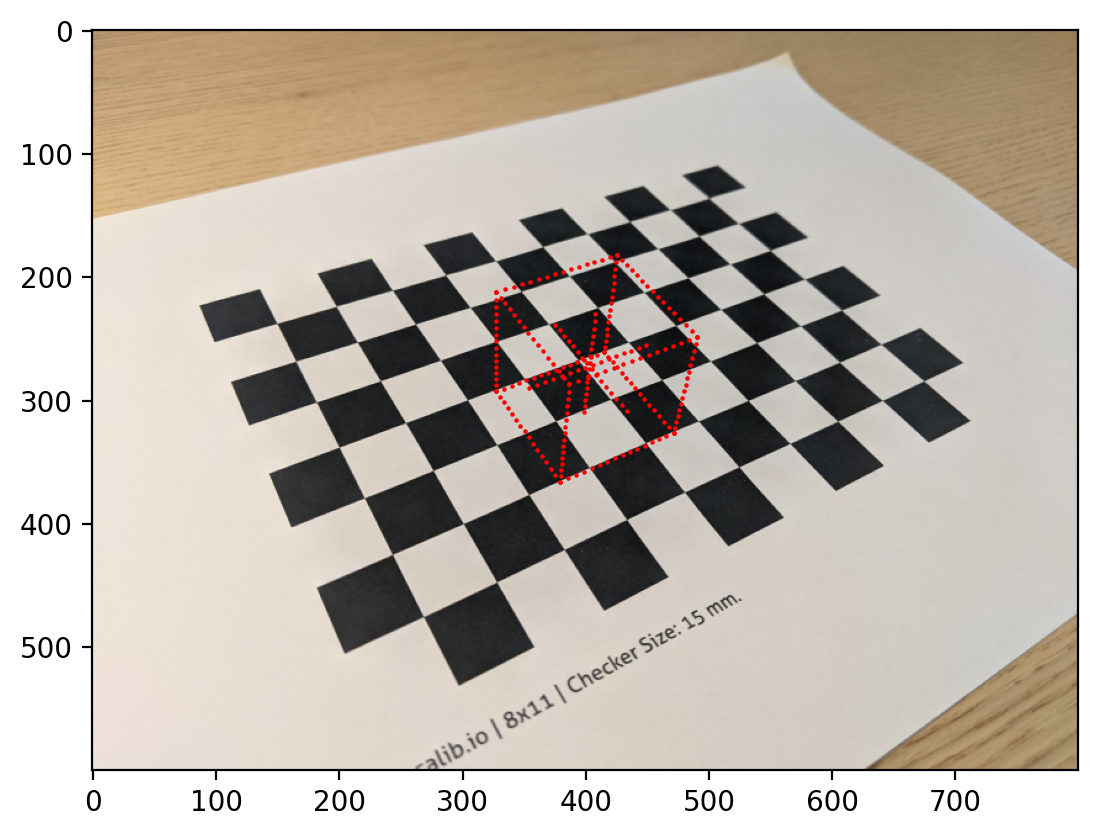

In [343]:
# 5.10
img_id_to_show = 4
Q = 2 * box3d() + 1
Qa = projectpoints(K, rotation_matrices[img_id_to_show], tvecs[img_id_to_show], Q)
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection=None)
ax.scatter(*Qa, c='r',s=0.4)
ax.imshow(small_ims[img_id_to_show])
plt.show()

In [341]:
# 5.11
# I don't find it necessary to solve this problem, since the results are already good enough